# FRAUD DETECTION

###   PART 1: EDA, PRE-PROCESSING & FEATURE ENGINEERING
- A. EDA with Graphs: visualize user-recipient relationships
- B. Data preprocessing: convert object columns
- C. Dimensionality reduction: remove correlated features
- D. Feature engineering: apply features to X, y

### PART 2: TRAIN MODEL
- A. Compare models: anomaly detection, ensemble, random forest
- B. Random Forest Classifier with SMOTE
- C. Improving the model: hyperparameter tuning & feature importance


### PART 3: QUALITATIVE ANALYSIS OF MODEL'S PERFORMANCE
- A. Evaluate losses: financial, qualitative, emotional losses
- B. Cost Minimization
- C. Implement an interface to the model
- D. Evaluate the model on a test set
- E. Decision paths

### PART 4: PREPARE FOR PRODUCTION

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

#   PART 1: EDA, PRE-PROCESSING & FEATURE ENGINEERING


# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [205]:
# imports
from typing import Dict, Any
import pandas  as pd
import numpy as np
from IPython.display import display as disp
from IPython.display import Image
from os.path import isfile

from datetime import datetime, time
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite

from sklearn import preprocessing
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

#conda install -c glemaitre imbalanced-learn
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
#from sklearn.svm import OneClassSVM as onesvm
#from sklearn.neighbors import LocalOutlierFactor as lof

# hide warnings
import warnings
warnings.filterwarnings("once")
warnings.filterwarnings("ignore") 

# Pipeline
from sklearn.preprocessing import FunctionTransformer
import pickle
from sklearn.pipeline import Pipeline

# Random Classifier Graph
from sklearn.tree import export_graphviz
from subprocess import call
#from graphviz import render
#conda install python-graphviz
#conda install -c alubbock pygraphviz
import pygraphviz
import graphviz
#from pygraphviz import render     #not rendering here

In [4]:
# Merge 2 CSV files, create 1 column for is_fraudulent
def read_data():
    txs = pd.read_csv('tx_data.csv') # Read data out of csvs file    
    
    # join on txs, label each tx
    txs = txs[[col for col in txs.columns if 'Unnamed' not in col]] #tx_data df
    labels = pd.read_csv('tx_labels.csv')[['tx_id', 'is_fraudulent']] # tx_labels
    data = txs.merge(labels, on='tx_id') # merge tx_id
    data = data[data["recipient_identifier"].notnull()]
    
    for col in ['card_first_used', 'user_created', 'recipient_created', 'tx_created']:
        data[col] = pd.to_datetime(data[col]) #time format
    
    return data

### make extra copies
network = read_data() #graphs
data = read_data() #data preprocessing
df = read_data() #evaluating
test = read_data() #experimenting

# -------------------------------------------------------------------------
## EDA WITH GRAPHS (Part 1.A)
# -------------------------------------------------------------------------

In [7]:
# NETWORK DATA: compare graphs
non = network[network['is_fraudulent'] == "f"].sample(n=100)
fraudulent = network[network['is_fraudulent'] == "t"].sample(n=20)
sample = pd.concat([non, fraudulent], ignore_index=True)
objs = sample[['u_id', 'recipient_identifier', 'is_fraudulent']]
objs["colour"] = objs["is_fraudulent"].apply(lambda val: "grey" if val == "f" else "red")
objs.drop('is_fraudulent', axis=1, inplace=True)

# Add nodes and edges for user-recipient connections
G=nx.from_pandas_edgelist(objs, 'u_id', 'recipient_identifier', edge_attr=True, create_using=nx.MultiDiGraph())
G.add_nodes_from(objs["u_id"], bipartite="user")
G.add_nodes_from(objs["recipient_identifier"], bipartite="recipient")
bipartite.is_bipartite(G)

# # Create colour maps for the nodes ('people' - users/recipients) & edges ('results' - fraud)
# # WARNING: adjust list length for the colour-map to work

# results = list(objs['colour'])#[0:len(results)+1]
# people = []
# for n in G.nodes():
#     if G.node[n]["bipartite"] == "user":
#         people.append('blue')
#     else: people.append('green')

# # DRAW NETWORK
#nx.draw_networkx(G, with_labels=False, edge=edges, node_size=1, node_color=people, edge_color=results, edge_size=30)

# BIPARTITE KEYWORD: a node cannot be connected to another node in the same partition
def get_nodes_from_partition(G, partition):
    nodes = []
    for n in G.nodes():
        if G.node[n]['bipartite'] == partition:
            nodes.append(n)
    return nodes
#print(len(get_nodes_from_partition(G, 'user')))
#print(len(get_nodes_from_partition(G, 'recipient')))


    # # DEGREE CENTRALITY: How connected are the nodes? - conclusion: fraud DC >> non-fraud DC
    # deg_cent = nx.degree_centrality(G)
    # degrees = [len(list(G.neighbors(n))) for n in G.nodes()]

    # # DEGREE CENTRALITY DISTRIBUTION: fraud user nodes - conclusion: fraudulent users have just 2 values, non-fraud are more scattered
    # user_nodes = get_nodes_from_partition(G, 'user')
    # dcs = nx.degree_centrality(G)
    # user_dcs = [dcs[n] for n in user_nodes]

    # # BETWEENNESS CENTRALITY: all possible shortest paths between pairs of nodes - conclusion: fraudulent recipients >> more connected than non-fraud
    # bet_cen = nx.betweenness_centrality(G)

    # # DEGREE CENTRALITY ON PROJECTION
    # #[n for n, d in G.nodes(data=True) if d['key'] == 'some_value']
    # users = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'user']
    # projected_users = nx.bipartite.projected_graph(G, users)
    # recipients = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'recipient']
    # x = nx.degree_centrality(projected_users)

    # # BIPARTITE DEGREE CENTRALITY HISTOGRAM: discrete values due to small sample of connections
    # original_dc = nx.bipartite.degree_centrality(G, recipients)


- red edges = fraudulent transactions
- blue dots = users
- green dots = recipients

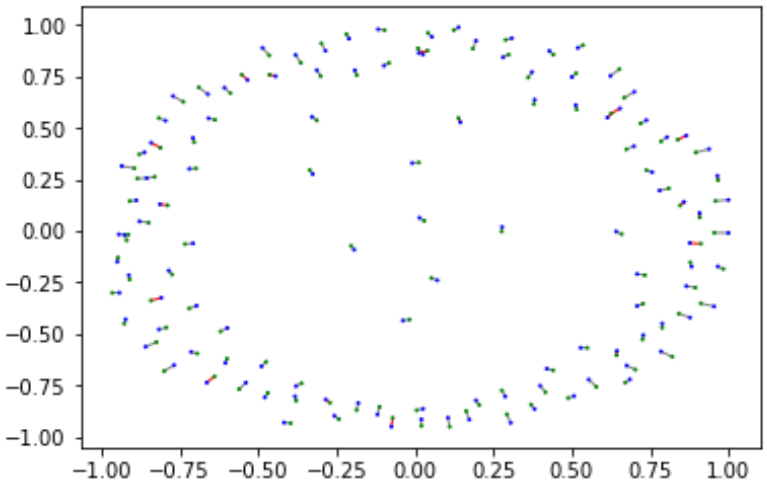

# -------------------------------------------------------------------------
## DATA PRE-PROCESSING (Part 1.B)


##### Extract interesting features from the category, datetime and object columns.

________
### i. OBJECT COLUMNS

##### Categorize 
- `receive_currency`: create dummy variables for each of the 4 recipient countries (Ghana, Kenya, Tanzania, Uganda)


##### Convert the incorrectly-labeled numerical columns into objects (assuming they hold no numerical or ordinal value)

- `tx_id`
- `p_id`
- `r_id`
- `u_id` 
- `s_id`
- 4 new categories


##### Remove redundant columns:
- `tx_id`: all unique, not numerical
- `p_id`: assume that `card_identifier` provides more info
- `r_id`: assume that `recipient_identifier` provides more info
- `send_currency`: homogenous column

##### Encode binary variables
- `is_fraudulent`: 0 for false, 1 for true

##### Keep users & recipients for now, will be good for graphs
- `u_id`, `recipient_identifier`

##### Keep ip & session identifiers for now, good for EDA with ratios
- `s_id`, `ip_identifier`, `card_identifier`

________
### ii. DATETIME COLUMNS

##### Create numerical 'age' columns
- `user_id_age`: age in days before transaction
- `recipient_id_age`: age in days before transaction
- `card_age`: card days in use before transaction
- `days_since_tx`: days since transaction until today


##### To look for user patterns & anomalies, replace datetime columns with transaction month, day, hour
- `tx_month`
- `tx_day`
- `tx_hour`

___

### iii. GROUP RELATIONSHIPS

##### What is 'normal' account activity? Are there networks? (This will help us detect deviations / anomalies)
- `outgoing` : count of user's beneficiaries
- `incoming`: count of a recipient's donor sources
- `ratio`: ratio of the 2 counts 
- `reused_sessions`: relationship to users, IPs?
- `reused_IPs`


# -------------------------------------------------------------------------

In [8]:
# Categorize receive_currency
data = pd.get_dummies(data, columns=['receive_currency'])
data.rename(columns={'receive_currency_GHS': 'Ghana','receive_currency_KES': 'Kenya', 'receive_currency_TZS': 'Tanzania', 'receive_currency_UGX': 'Uganda'}, inplace=True)

In [9]:
# Convert int64 to object type
data[["tx_id", "u_id", "r_id", "p_id", "Ghana", "Kenya", "Tanzania", "Uganda"]] = data[["tx_id", "u_id", "r_id", "p_id", "Ghana", "Kenya", "Tanzania", "Uganda"]].astype('object')

In [10]:
# remove any object columns with highest frequency == 1, or containing unique == 2200888
drop_cols = [col for col in data if data[col].nunique() == 1 or data[col].nunique() == 220888 and data[col].dtype == 'object']
data.drop(drop_cols, axis=1, inplace=True)

In [11]:
# remove redundant database keys: 
data.drop(["r_id", "p_id"], axis=1, inplace=True)

In [12]:
# convert "is_fraudulent" to boolean
data["is_fraudulent"] = data["is_fraudulent"].apply(lambda val: 0 if val == "f" else 1)

In [13]:
# Create "age" columns
data["user_id_age"] = data['tx_created'].subtract(data['user_created']).astype('timedelta64[D]')
data["recipient_id_age"] = data['tx_created'].subtract(data['recipient_created']).astype('timedelta64[D]')
data["card_age"] = data['tx_created'].subtract(data['card_first_used']).astype('timedelta64[D]')
data["days_since_tx"] = data['tx_created'].subtract(datetime.now().date()).astype('timedelta64[D]')*(-1)

In [14]:
# Create transaction month, day, hour columns
data["tx_month"] = data["tx_created"].apply(lambda row: row.month)
data["tx_day"] = data["tx_created"].apply(lambda row: row.day)
data["tx_hour"] = data["tx_created"].apply(lambda row: row.hour)
data['daily_payout'] = data['send_amount']/(0.1 + data['tx_created'].subtract(data['card_first_used']).astype('timedelta64[D]'))

In [15]:
# group the user's dependents and the recipients' donors
data['u_payees'] = data.groupby(['u_id'])['recipient_identifier'].transform('size') 
data['r_donors'] = data.groupby(['recipient_identifier'])['u_id'].transform('size')
data['payees:donors'] = data['u_payees']/data['r_donors']

In [21]:
# grouped sessions, IDs, cards
data['reused_sessions'] = data.groupby(['s_id'])['ip_identifier'].transform('size') 
data['reused_ips'] = data.groupby(['ip_identifier'])['s_id'].transform('size') 
data['reused_cards'] = data.groupby(['card_identifier'])['u_id'].transform('size') 

In [22]:
# Reorder & keep numerical columns
num = data[['is_fraudulent', 'send_amount', 'Ghana', 'Kenya', 'Tanzania', 'Uganda', 'daily_payout', 'user_id_age', 'recipient_id_age', 'card_age', 'days_since_tx', 'tx_month', 'tx_day', 'tx_hour', 'u_payees', 'r_donors', 'payees:donors', 'reused_sessions', 'reused_ips', 'reused_cards']]

# -------------------------------------------------------------------------

## DIMENSIONALITY REDUCTION (Part 1.C)



##### Plot the relationships! Which features move independently?

- Drop dependently correlated features: df.corr() ~1.00 & std ~ 0
- Keep high variance features: std ~ 1
    
##### Conclusions:
Visual fraudulent clusters appear in these columns
- `card_age`
- `r_donors`
- `reused_session`
- `daily_payouts`

# -------------------------------------------------------------------------

In [26]:
# SAMPLED NUMERICAL DATA: compare visual clusters of fraud. (To avoid overfitting, I took only 300 samples of fraud)
    # diagonally lines indicate column correlations: drop 1
none = num[num['is_fraudulent'] == 0].sample(n=1000)
fraud = num[num['is_fraudulent'] == 1].sample(n=300)
numbrs = pd.concat([fraud, none], ignore_index=True)

In [27]:
# I iteratively removed features that had high correlations & few clusters
reduced = numbrs[['is_fraudulent', 'send_amount', 'daily_payout', 'user_id_age', 'recipient_id_age', 'card_age', 'tx_hour', 'u_payees', 'r_donors', 'reused_sessions']]

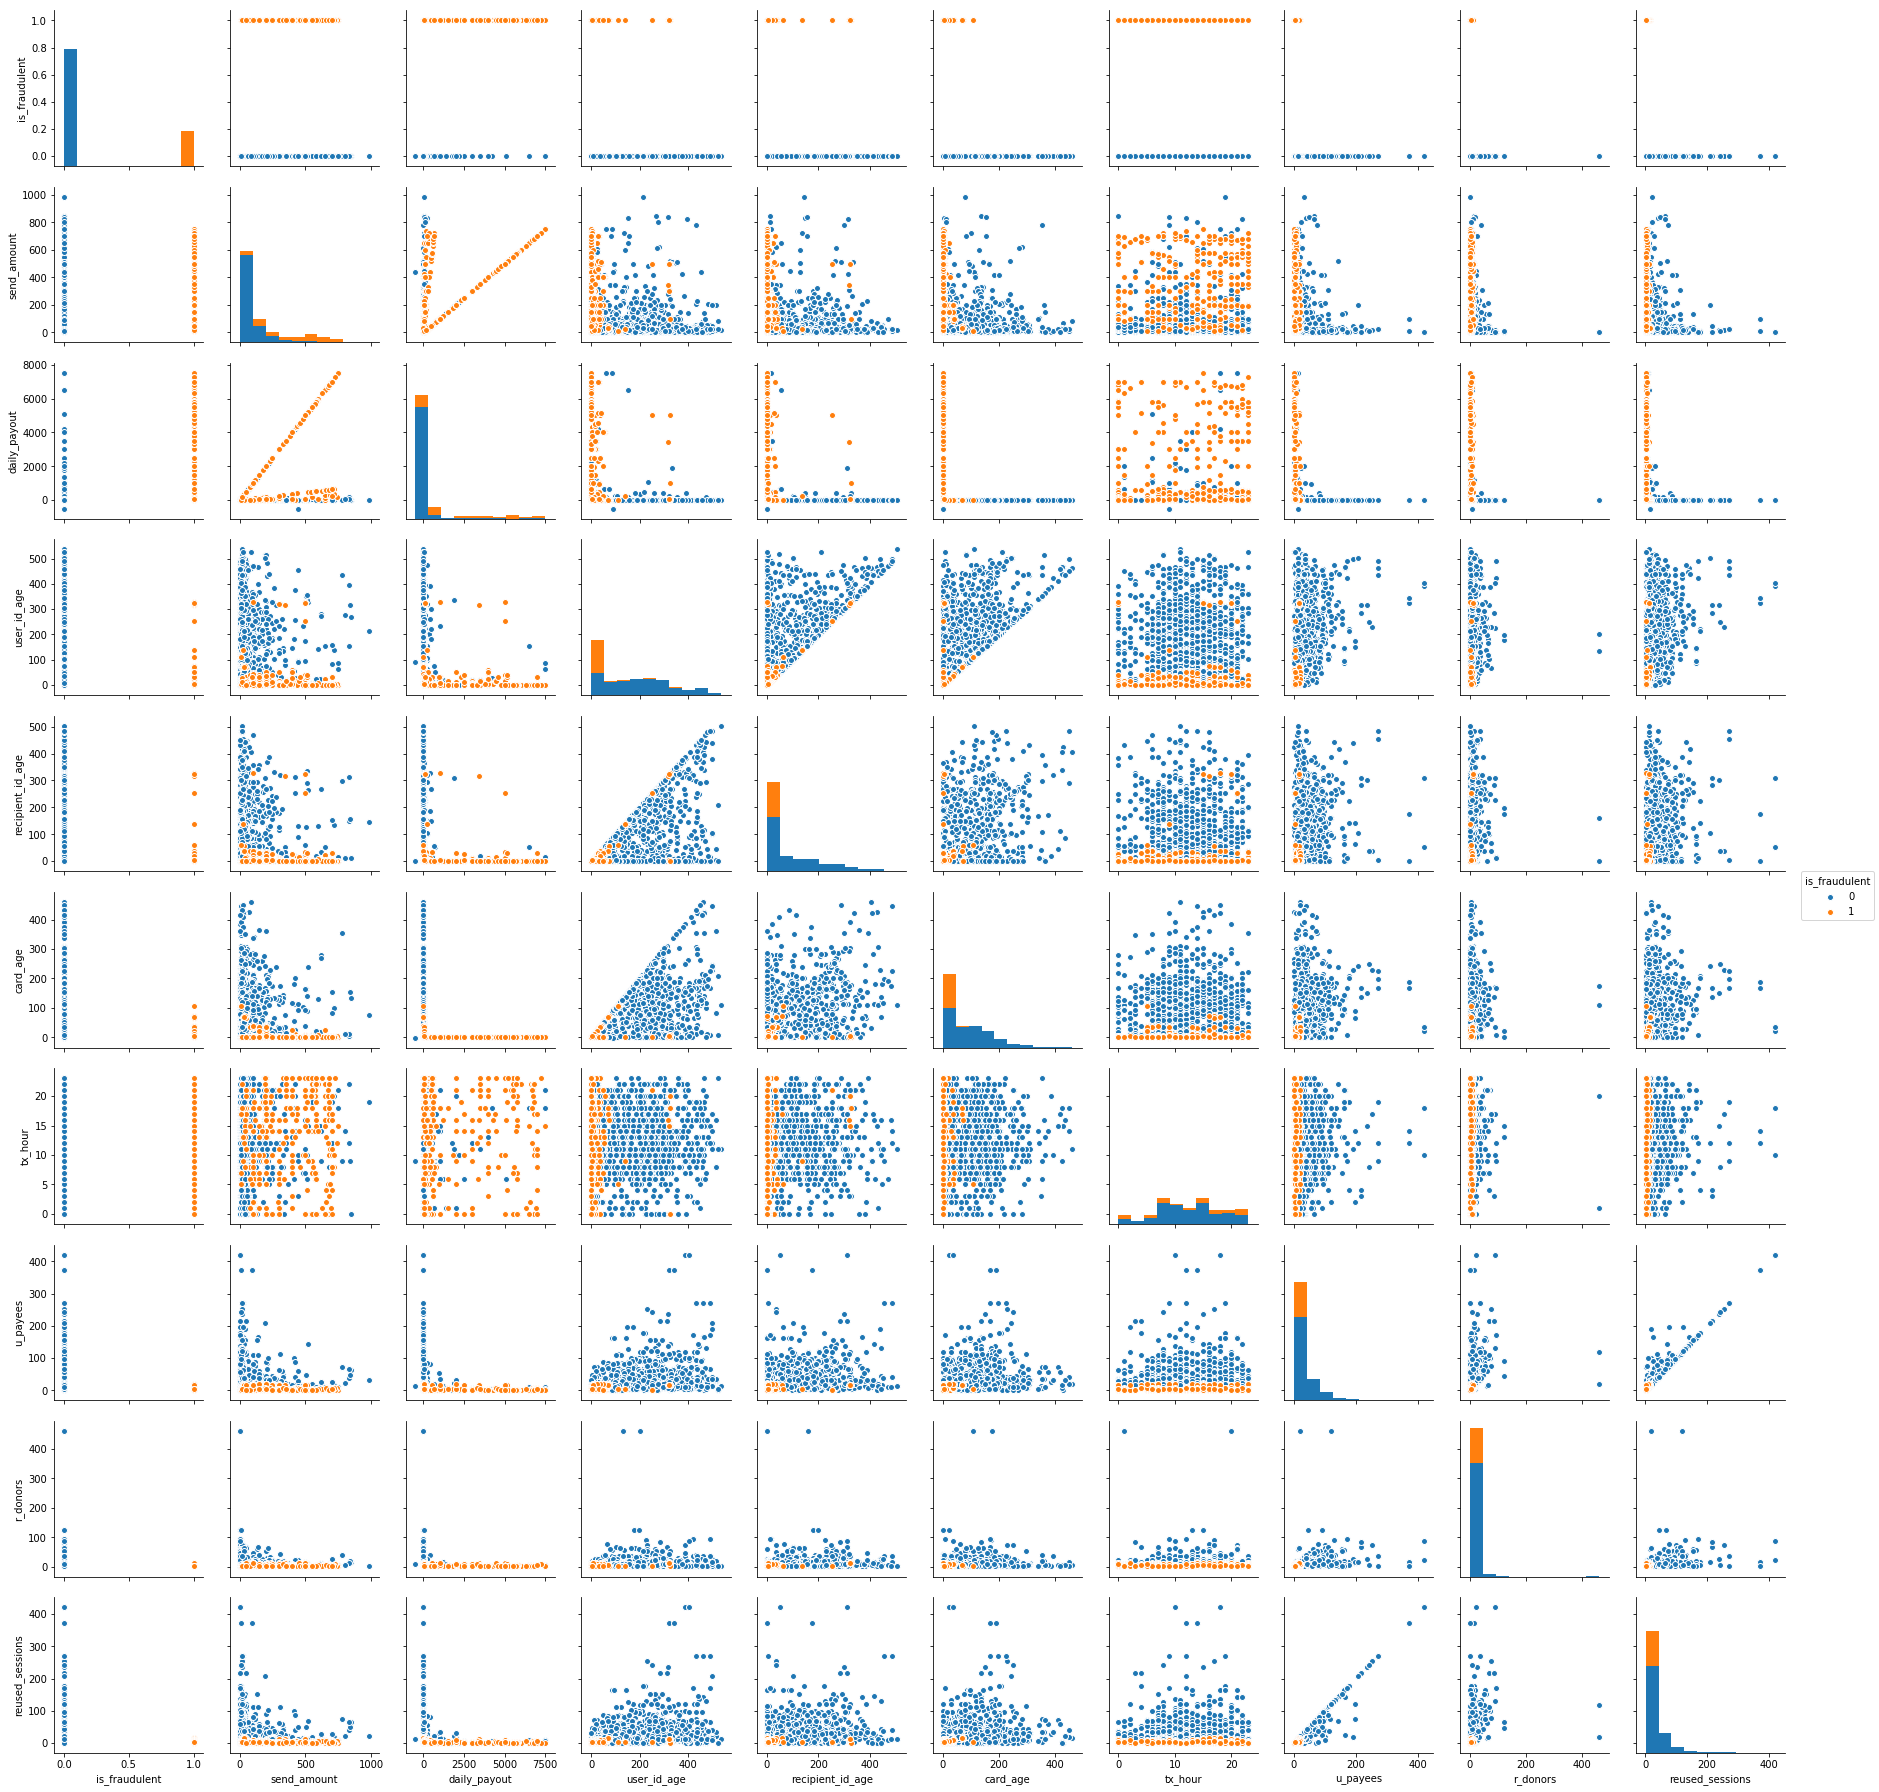

In [28]:
sns.pairplot(reduced, hue="is_fraudulent", diag_kind='hist')

# -------------------------------------------------------------------------
## FEATURE ENGINEERING (Part 1.D)

# -------------------------------------------------------------------------
##### Apply these features:
- `is_fraudulent`
- `send_amount`
- `daily_payout`
- `user_id_age`
- `recipient_id_age`
- `card_age`
- `tx_hour`
- `u_payees`
- `r_donors`
- `reused_sessions`


In [29]:
# Hiding the warnings to avoid scrolling between adjacent cells.
import warnings
warnings.filterwarnings("ignore") 

In [40]:
def featurize_to_Xy(df):
    X = df[['send_amount']]
    X['card_age'] = df['tx_created'].subtract(df['card_first_used']).astype('timedelta64[D]')
    X['user_id_age'] = df['tx_created'].subtract(df['user_created']).astype('timedelta64[D]')
    X['recipient_id_age'] = df['tx_created'].subtract(df['recipient_created']).astype('timedelta64[D]')
    X['tx_hour'] = df["tx_created"].apply(lambda row: row.hour)
    X['daily_payout'] = df['send_amount']/(0.1 + df['tx_created'].subtract(df['card_first_used']).astype('timedelta64[D]'))
    X['u_payees'] = df.groupby(['u_id'])['recipient_identifier'].transform('size') 
    X['r_donors'] = df.groupby(['recipient_identifier'])['u_id'].transform('size')
    X['reused_sessions'] = df.groupby(['s_id'])['ip_identifier'].transform('size')
    X["KES"] = df["receive_currency"].apply(lambda val: 1 if val =='KES' else 0)
    X["GHS"] = df["receive_currency"].apply(lambda val: 1 if val =='GHS' else 0)
    X["TZS"] = df["receive_currency"].apply(lambda val: 1 if val =='TZS' else 0)
    X["UGX"] = df["receive_currency"].apply(lambda val: 1 if val =='UGX' else 0)
#   X['payees:donors'] = (df.groupby(['u_id'])['recipient_identifier'].transform('size') )/(df.groupby(['recipient_identifier'])['u_id'].transform('size')+0.1)
#   X["days_since_tx"] = df['tx_created'].subtract(datetime.now().date()).astype('timedelta64[D]')*(-1)
    X["tx_month"] = df["tx_created"].apply(lambda row: row.month)
    X["tx_day"] = df["tx_created"].apply(lambda row: row.day)
#   X['reused_ips'] = df.groupby(['ip_identifier'])['s_id'].transform('size') 
    X['reused_cards'] = df.groupby(['card_identifier'])['u_id'].transform('size') 
    y = df['is_fraudulent'] == "t"

    return X, y

In [41]:
#Featurize our dataframe
X, y = featurize_to_Xy(df)

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# PART 2: TRAIN MODEL 

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


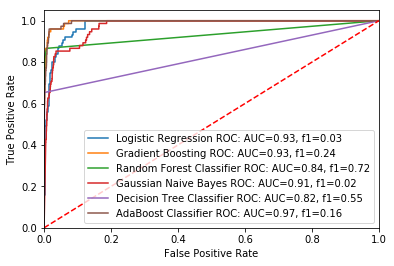

In [191]:
# ATTEMPT 1: ANOMALY DETECTION: LOCAL OUTLIER FACTOR (LOF)
    # CONCLUSION: Unsuccessful, 24 TP & 1091 FP
"""
    yy = df["is_fraudulent"].apply(lambda val: 1 if val == "f" else -1)
    return Xx, yy
Xx, yy = featurize_to_Xy(df)

y_pred = lof(contamination=np.mean(y==-1.0)).fit_predict(X)
tn, fp, fn, tp = confusion_matrix(yy, y_pred).ravel()
print(classification_report(y_pred, yy))
"""

# ATTEMPT 2: ENSEMBLE METHOD
    # CONCLUSION: Random Forest works best alone. (Tried manual parameter tuning too)
"""
clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()
clf4 = DecisionTreeClassifier()
ensemble_model = VotingClassifier(estimators=[('lr', clf1),('rf', clf2),('gnb', clf3), ('dt', clf4)], voting='soft', weights=[1,10,1,1])
ensemble_model.fit(X_train, y_train)
predicted = ensemble_model.predict(X_test)
"""

# ATTEMPT 3: PLOT SIX MODELS, COMPARE FOR F1 SCORE
plt.figure()

models = [
    {
        'label': 'Logistic Regression',
        'model': LogisticRegression(C=10, random_state=12),
    },
    {
        'label': 'Gradient Boosting',
        'model': GradientBoostingClassifier(random_state=12),
    },
    {
        'label': 'Random Forest Classifier',
        'model': RandomForestClassifier(random_state=12),
    },
    {
        'label': 'Gaussian Naive Bayes',
        'model': GaussianNB(),
    },
    {
        'label': 'Decision Tree Classifier',
        'model': DecisionTreeClassifier(random_state=12),
    },
    {
        'label': 'AdaBoost Classifier',
        'model': AdaBoostClassifier(random_state=12)
    }]

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=12)
x_train_rs, y_train_rs = SMOTE(kind='borderline1').fit_sample(x_train, y_train)
 
# Train each model, get f1 score
for m in models:
   
    classifier = m['model'].fit(x_train_rs, y_train_rs) # fit on random sample
    
    y_pred = classifier.predict(x_test) # predict the test data
    y_proba = classifier.predict_proba(x_test)[:,1] #predict prob of 0 and 1
    
    # ROC Curve
    fpr, tpr, thresh = roc_curve(y_test, y_proba)
    
    # Area under the curve
    auc = roc_auc_score(y_test, y_pred)
    
    # f1 score:
    f1 = f1_score(y_test, y_pred)
    
    # Plot for each model
    plt.plot(fpr, tpr, label='%s ROC: AUC=%0.2f, f1=%0.2f' % (m['label'], auc, f1))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()   # Display

# -------------------------------------------------------------------------
## THE WINNER: 
## RANDOM FOREST CLASSIFIER + SMOTE SAMPLING! (Part 2.B)

##### Why Random Forest?
- Highest F1 score
- Lowest numer of false negatives (undected fraud)

##### Deal with class imbalance
- use SMOTE (Synthetic Minority Oversampling Technique)

# -------------------------------------------------------------------------

In [49]:
# RANDOM FOREST CLASSIFIER + SMOTE SAMPLING
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)    # done above
X_train_smote, y_train_smote = SMOTE(kind='borderline1').fit_sample(X_train, y_train) #Synthetic minority oversampling technique

# Train the Random Forest Classifier rf_model
rf_model = RandomForestClassifier(n_estimators=250, class_weight='balanced_subsample', random_state=12, n_jobs=-1).fit(X_train_smote, y_train_smote)#, sample_weight=u_payees)

In [51]:
# Rule out overfitting: 10-fold cross validation
scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=10) # split training into 10 subsets
print(f"Average accuracy of 10-fold cross validation: {np.mean(scores)} %")
print("-------------------------------------------------------------------")
print('Number of folds outperforming 99.82% natural accuracy: ', len(scores[scores>.9982]))
print("-------------------------------------------------------------------")
print(scores)

Average accuracy of 10-fold cross validation: 0.9993900980559811 %
-------------------------------------------------------------------
Numer of folds outperforming 99.82% natural accuracy:  9
-------------------------------------------------------------------
[0.99541154 0.9998575  0.999829   0.99985749 0.99974349 0.999943
 0.99974349 0.99985749 0.99985749 0.99980049]


In [186]:
# Predict accuracy of rf_model on X_test
y_pred = rf_model.predict(X_test)
print("Accuracy score: ", (accuracy_score(y_test, y_pred)*100), "%")
print("Accuracy score to beat (natural accuracy): 99.82%")
print("-------------------------------------------------------------------")

# Evaluate the model
print("Classification Report: ")
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(classification_report(y_test, y_pred))
print("-------------------------------------------------------------------")
print("Fraudsters caught: ",tp)
print("Sneaky undetected fraudsters: ", fn)
print("Framed innocent users: ", fp)
print(f"True good guys: {tn:,}")

Accuracy score:  99.92945246006099 %
Accuracy score to beat (natural accuracy): 99.82%
-------------------------------------------------------------------
Classification Report: 
             precision    recall  f1-score   support

      False       1.00      1.00      1.00     43867
       True       0.85      0.71      0.77        75

avg / total       1.00      1.00      1.00     43942

-------------------------------------------------------------------
Fraudsters caught:  53
Sneaky undetected fraudsters:  22
Framed innocent users:  9
True good guys: 43,858


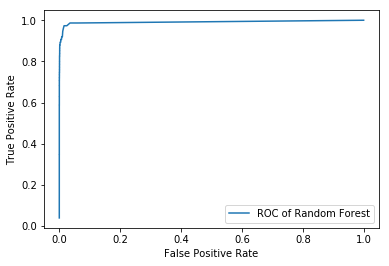

In [55]:
### Evaluate the model
%matplotlib inline
proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, proba)
plt.plot(fpr, tpr, label='ROC of Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# -------------------------------------------------------------------------
## IMPROVING RANDOM FOREST CLASSIFIER (Part 2.C)
# -------------------------------------------------------------------------

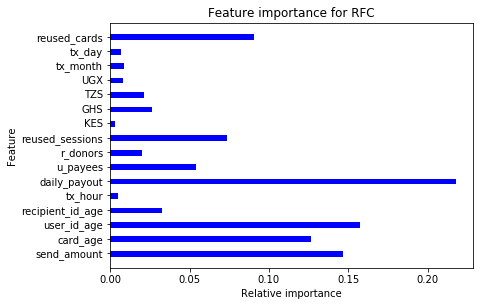

In [56]:
# PLOT THE FEATURE IMPORTANCE

fig, ax = plt.subplots()

# set the width of the bars
width=0.4

# X locations for the groups
ind = np.arange(len(rf_model.feature_importances_)) #set vertical axis
ax.barh(ind, rf_model.feature_importances_, width, color='blue') # make the importances blue
ax.set_yticks(ind+width/10) #y column locations
col=X_train.columns[ind] # hide the above locations
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance for RFC')
plt.xlabel('Relative importance')
plt.ylabel('Feature')
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)

In [162]:
# TEST OUT NEW FEATURES
#np.mean(df[df['is_fraudulent']=="t"])
#data.groupby('is_fraudulent').mean()
#data[data['is_fraudulent']==1].max()
#card_age = [0.2 if days > 5 else 1.0 for days in X_train['card_age']]
#data.groupby('is_fraudulent').mean()

# CREATE SAMPLE WEIGHTS
# pounds = [0.2 if p < 250 else 1.0 for p in X_train_smote['send_amount']]
# card_age = [0.1 if days > 4 else 1.0 for days in X_train_smote['reused_sessions']]
# daily_payout = [0.2 if pay < 250 else 1.0 for pay in X_train_smote['daily_payout']]
# recipient_id_age = [0.3 if age > 5 else 1.0 for age in X_train_smote['recipient_id_age']]
# reused_sessions = [0.3 if sessions > 4 else 1.0 for sessions in X_train_smote['reused_sessions']]
# u_payees = [0.3 if payees > 6 else 1.0 for payees in X_train_smote['u_payees']]

# FIT WITH SAMPLE WEIGHTS
#rf_model = RandomForestClassifier(random_state=12).fit(X_train_smote, y_train_smote, sample_weight=pounds)
#rf_model = RandomForestClassifier(n_estimators=250, class_weight='balanced_subsample', random_state=12, n_jobs=-1).fit(X_train_smote, y_train_smote)#, sample_weight=u_payees)

# TRAIN WITH TUNED PARAMETERS
#rf_model = RandomForestClassifier(n_estimators=10, class_weight={0:1,1:12}, criterion='entropy', max_depth=8, max_features='log2', min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=12).fit(X_train_smote, y_train_smote)
#rf_model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy', max_depth=10, min_samples_leaf=10, n_estimators=20, n_jobs=-1, random_state=12).fit(X_train_smote, y_train_smote)
#rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy', max_depth=None, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1, oob_score=False, random_state=12, verbose=0, warm_start=False).fit(X_train_smote, y_train_smote)


# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# PART 3: EVALUATE THE MODEL 

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


# -------------------------------------------------------------------------
## EVALUATING LOSSES (Part 3.A)





### i. FINANCIAL LOSSES

##### Price of a false negative: £360
- Company lost £147,310.03 to fraud (in this dataset)
- On average, fraudulent transactions cost £360.17 in chargebacks
    - Since X_test represents only a 1/5 of the dataset, for an overall cost estimate, we should should multiply each FN by 5

##### Price of a false positive: £18
- Users send £82.57 on average, and company charges about 3-4% commission. A false positive resembles a fraudulent transaction, so let's assume the user was trying to send £360.
- Your goal is to reduce 'reviews', which I'll overestimate at  £4. (Labour cost = 20 minutes at  £12/hour)
- Therefore, the cost of a FP = (£360)(0.04) +  £5 =  £18.40


### ii. QUALITATIVE & EMOTIONAL LOSSES

##### False Negative = SUCCESSFUL SCAMMER
- Reputation! Look what happened with Bitcoin. If you start facilitating fraud, your services will attract more scammers. 
- Technology! Scammers can fund VPNs (to mask online identities), packet analyzers, high-RAM PCs for decrypting data, etc.

##### False Negative = DISTRESSED VICTIM
- Emotional stress and financial hardship for the victims, even if temporary. 
    - Every fraudulent transaction has a backstory: if someone's card was stolen, then their whole wallet is probably gone too, and possibly their phone... so they can't even call their bank, or buy a new phone!

    
##### False Positive = FRUSTRATED RECIPIENT
- Emotional stress: if a transaction resembled fraud, it's because the user was sending large amounts of money with extreme urgency. This  indicates that the recipient (a Kenyan, Tanzanian, Ghanaian, or Ugandan) could be in some sort of trouble, or has to pay a bill urgently. 
- However, the emotional stress will last a maximum of 2 days, since the user can send the money using Transferwise instead.


####  ~ ~ ~ ~ ~ ~  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~  ~ ~ ~ ~ ~

#### Compare the situations of an FP versus an FN:


##### THE FALSE POSITIVE (user story example)
An animal sanctuary in Africa gets a call about a chimpanzee orphan who needs rescuing, but the main office can't afford airplane fuel and equipment. Their UK donors are urged to send money ASAP, but Company blocks the transaction. The staff have to pay everything out-of-pocket, and wait for the charity money to arrive in 2 days via Transferwise. (Had to use my imagination to think of a truly urgent FP situation that couldn't be solved immediately with a British credit card).

##### THE FALSE NEGATIVE (user story example)
A UK tourist is on vacation in Tanzania to hike Kilimanjaro, but her purse is stolen. The robber Googles "service for sending money to Africa, low security", and proceeds to make a Company account using the info in his victim's wallet. He sends himself £360 repeatedly. The tourist needs to pay for an expedited passport so she can go home, but she discovers her account is empty, and she doesn't have cash or a credit card. She has to borrow the hostel's phone to call her bank and then wait 7 days for them to reverse the charges. The robber recommends his friends pick-pocket British tourists and then send themselves money with Company.


#### MY VERDICT: False negatives are 5 x as consequential as false positives
A false-negative has wider-reaching consequences. (Taking into account time delays and local purchasing power.)


# -------------------------------------------------------------------------

In [ ]:
def loss_scorer(y_test, predicted, cost_fp=18, cost_fn=360):
    tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
    return cost_fp*fp + cost_fn*fn

curr = 147310
estimate = loss_scorer(y_test, y_pred) * 5
saved = curr - estimate
perc = int(saved/curr*100)
print("Company's EXISTING chargeback losses in dataset: £147,310")
print(f"Amount of money saved with new model:   £{saved:,}")
print(f"Percentage of fraud reduction thanks to model: {perc}%")


In [70]:
def tears_counter(y_test, predicted, cost_fp=1, cost_fn=5):
    tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
    return cost_fp*fp + cost_fn*fn

previous_tears = 409 * 5
print(f"Emotional price, using existing model: {previous_tears:,} tears")

tears_shed = int(tears_counter(y_test, y_pred) * 5)
print(f"Emotional price, using new ML model: {tears_shed} tears")

Emotional price, using existing model: 2,045 tears
Emotional price, using new ML model: 595 tears


# -------------------------------------------------------------------------
## COST MINIMIZATION (Part 3.B)
# -------------------------------------------------------------------------

In [ ]:
# OPTIMIZED THRESHOLD

# label the test data using rf_model, then get FPs and FNs
pred_labels = rf_model.predict(X_test)
ground_truth = y_test
tp, fp, fn, tn = confusion_matrix(ground_truth, pred_labels).ravel()

# score test data using rf_model
proba_scores = rf_model.predict_proba(X_test)

# do these scores exceed threshold 0.5?
#[score[1]>0.5 for score in proba_scores] == rf_model.predict(X_test)
#tn, fp, fn, tp = confusion_matrix(ground_truth, predicted).ravel()

# -------------------------------------
# CONFIRM THAT CLASSIFIER USES DEFAULT CLASSIFICATION THRESHOLD 0.5

# compare with default
pred_score_labels = [s[1] > 0.5 for s in proba_scores]
all(pred_score_labels == pred_labels)

# -------------------------------------
# OPTIMIZE THRESHOLD

# Create a range of equally spaced threshold values
threshold_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# for each threshold value, store predicted proba_scores
thres_preds = [[score[1] > threshold for score in proba_scores] for threshold in threshold_range]

# Compute accuracy for each threshold
accuracies = [accuracy_score(ground_truth, p) for p in thres_preds]

# Compute F1 score for each threshold
f1_scores = [f1_score(ground_truth, p) for p in thres_preds]

# Report their optimal thresholds
t_range[np.argmax(accuracies)], t_range[np.argmax(f1_scores)]
#lower_tolerance = (proba_scores[:,1] >= 0.2).astype('int')

### Find the threshold for the minimum emotional loss

In [168]:
# Create a range of equally spaced threshold values
threshold_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# compute losses of all FP and FN in threshold range
min_costs = [tears_counter(ground_truth, [score[1] > threshold for score in proba_scores]) for threshold in threshold_range]
min_costs #thres_costs

#minimum tears are shed if we make our threshold 0.2!

[156, 111, 112, 120, 119, 137, 161, 172, 251]

# ------------------------------------------------------------------------------------------------------------


## IMPLEMENT AN INTERFACE TO THE MODEL (Part 3.C)


# ------------------------------------------------------------------------------------------------------------

#### Assumptions
- function `featurize_to_Xy(tx_data)` is available
- `rf_model` is already stored in memory

In [196]:
# Implement an interface to the model. Risk score a transaction based on the trained model. This transaction can be new, and not represented in the training data set.
# - Arguments in function score_transaction(tx_data): a dictionary containing the transaction data columns
            #assert len(tx_data.keys()) == len(expected_columns)    
            #for col in expected_columns:
            #    assert col in tx_data
# - expected_columns = ['tx_id', 'u_id', 'p_id', 'r_id', 'send_amount', 'send_currency', 'receive_currency', 'ip_identifier', 's_id', 'recipient_identifier', 'card_identifier', 'card_first_used', 'user_created', 'recipient_created', 'tx_created']
# - Featurize the transaction
# - Returns: a float representing the probability of the transaction being fraudulent

def score_transaction(tx_data):  
    if type(tx_data) == pd.DataFrame:
        X_new, _ = featurize_to_Xy(tx_data)  # ASSUME 'FEATURIZE_TO_XY()' FUNCTION IS STORED 
    elif type(tx_data) == np.ndarray:
        X_new = tx_data
    else:
        raise Exception("Unsupported datatype")
    return rf_model.predict_proba(X_new)    # ASSUME THE MODEL IS ALREADY STORED IN MEMORY

# ------------------------------------------------------------------------------------------------------------
## EVALUATE THE MODEL ON THE TEST SET (Part 3.D)
# ------------------------------------------------------------------------------------------------------------

#### Double-check that your interface works
- Run `score_transaction()` on `tx_id = 12319454`
- Problem: there is an 80% chance that it has been trained by rf_model

#### Use the remaining 20% of data in X_test to evaluate `score_transaction()`
- Create a dataframe from the predictions. Show the risk of fraud based on that account.

In [212]:
# ### double-check that your interface works
tx = df[df['tx_id'] == 12319454] # tx = data[data['tx_id'] == 12319454][[col for col in data if col != 'is_fraudulent']]
score_tran = score_transaction(tx)
print(f"Probability of risk for transaction #12319454: {score_tran}")   #  DATA INSTANCE HAS ALREADY BEEN TRAINED BY THIS MODEL

Probability of risk for transaction #12319454: [[1. 0.]]


In [213]:
# Run the remaining 20% of values, X_test values, through score_transaction
predict_X_test = score_transaction(X_test.values)
assert predict_X_test.shape[0], X_new.shape[0]           

    # Make a dataframe from the risk predictions, score_transaction(X_test.values)
pred_df = pd.DataFrame(predict_X_test, columns=['probably_normal','probably_fraud'], index=X_test.index)
print(f"# of transactions in X_test being evaluated for fraud: {pred_df.shape[0]:,}")
pred_df.head()

# of transactions in X_test being evaluated for fraud: 43,942


,probably_normal,probably_fraud
166160,1.0,0.0
138368,1.0,0.0
40830,1.0,0.0
415,1.0,0.0
66436,1.0,0.0


In [ ]:
# View the results between 0 and 100% probability certainty
inbetween = pred_df[(pred_df['probably_normal'].values<1.0) & (pred_df['probably_normal'].values>0.0)]

print(f"# of non-fraudulent transaction that require extra inspection: {inbetween.shape[0]:,}")
inbetween.head()

In [203]:
# Full transaction data, available for human inspection
inbetween_full = X_test.loc[(predict_X_test[:,0]!=1.) & (predict_X_test[:,0]>0.0)]
inbetween_full.head()

,send_amount,card_age,user_id_age,recipient_id_age,tx_hour,daily_payout,u_payees,r_donors,reused_sessions,KES,GHS,TZS,UGX,tx_month,tx_day,reused_cards
203599,23.00,0.0,55.0,55.0,14,230.000000,8,5,4,1,0,0,0,12,12,5
161913,200.00,40.0,40.0,40.0,23,4.987531,5,23,4,0,0,0,1,1,16,5
161047,180.00,21.0,21.0,20.0,14,8.530806,5,3,4,0,1,0,0,12,20,5
212386,198.28,9.0,469.0,0.0,8,21.789011,38,1,2,0,0,0,1,1,25,35
215491,29.00,0.0,0.0,0.0,22,290.000000,1,1,1,0,1,0,0,1,19,1


# -------------------------------------------------------------------------

## OBSERVE THE DECISION PATHS (Part 3.E)
- Write functions
- Test on 1 fraudulent transaction #193702
- Test on  fraudulent transaction #110771

# -------------------------------------------------------------------------

In [1]:
# Write the 4 important functions

def get_graph(estimator, feature_names, class_names, max_depth=4):
    graph=export_graphviz(estimator, out_file=None,
                    feature_names =feature_names,
                    class_names = class_names,
                    rounded = True, proportion = False, 
                    precision = 2, filled = True, node_ids=True, max_depth=max_depth)
    return graph


def format_decision_path(decision_path, verbose=True):
    node_ids = decision_path.nonzero()[1]
    path_nodes = np.insert(node_ids, 0, node_ids[0])
    path_nodes = [str(f"{path_nodes[i]} -> {path_nodes[i+1]} ;")
                  for i in range(1, path_nodes.size-1)]
    if verbose is True:
        print("The decision tree traversed in this order:")
        print("StartNode -> EndNode")
        for p in path_nodes:
            print(p)
    return path_nodes


def mark_path_traversed(path_nodes, graph):
    graph_list = graph.splitlines()
    list_indices = [idx for i in path_nodes for (
        idx, g) in enumerate(graph_list) if i in g]
    for list_idx in list_indices:
        line = graph_list[list_idx]
        mark_path = f'{line[:-1]} [color="red", penwidth=5];'
        graph_list[list_idx] = mark_path
        graph_list[list_idx]
    return graph_list


def visualize_path(graph_list, dot_file_name='graph_vis.txt'):
    with open(dot_file_name, 'w') as file:
        file.writelines(graph_list)
    # Make sure there's an actual file before trying to display it
    if isfile(dot_file_name) is True:
        return Image(render('dot', 'png', dot_file_name))
    else:
        print("UNABLE TO GENERATE PATH")

#### PLOT DECISION PATH FOR FRAUDULENT TRANSACTION #193702

send_amount             580
card_age                  1
user_id_age               1
recipient_id_age          1
tx_hour                  15
daily_payout        527.273
u_payees               True
r_donors               True
reused_sessions           3
KES                       0
GHS                       0
TZS                       0
UGX                       1
Name: 193702, dtype: object

fraud: True
Our random forest classifier is composed of 10 decision trees
The decision tree is traversed in this order:
StartNode -> EndNode
0 -> 562 ;
562 -> 563 ;
563 -> 564 ;
564 -> 730 ;
730 -> 762 ;
762 -> 763 ;
763 -> 764 ;
764 -> 766 ;
766 -> 767 ;
767 -> 768 ;
768 -> 769 ;
769 -> 770 ;
770 -> 771 ;
771 -> 772 ;
772 -> 773 ;
773 -> 774 ;
774 -> 776 ;
776 -> 777 ;
777 -> 778 ;
778 -> 868 ;
868 -> 894 ;
894 -> 902 ;


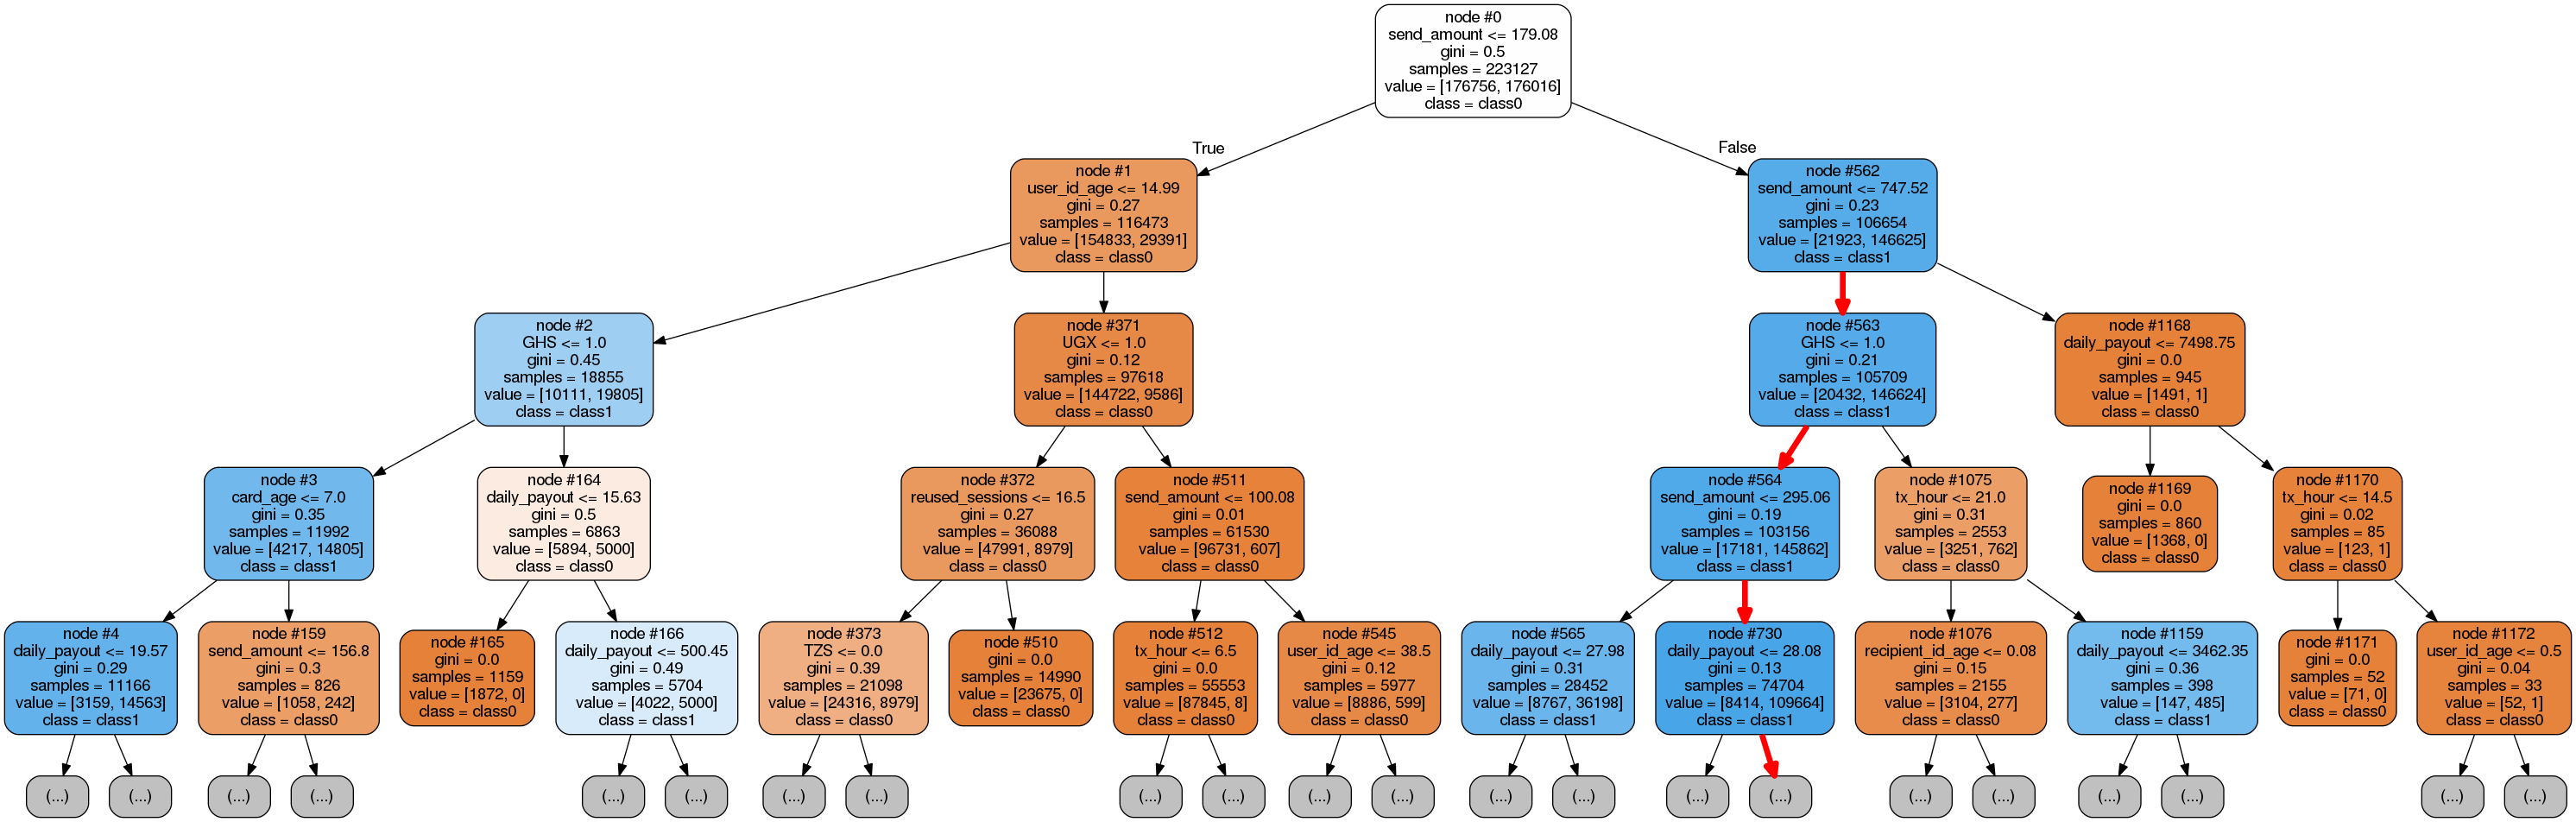

In [15]:
# Plot decision path for one of the trees for a known fraud case
idx=193702 # known fraud
one_sample = X_test.loc[idx]
disp(one_sample)
print('fraud:', y_test.loc[idx])
print(f"Our random forest classifier is composed of {len(rf_model.estimators_)} decision trees")

# Pick the 5th decision tree in the forset
estimator = rf_model.estimators_[5] 

# How was the prediction decided for the decision tree?
# Randomly select 1 of 10 decision trees, plot the path of a sample
decision_path = estimator.decision_path(one_sample.values.reshape(1,-1))

class_names = ['class0','class1']
feat_names = X_train.columns.values

# Get the nodes in the decision tree
path_nodes = format_decision_path(decision_path,verbose=True)

# Create graph visualization using graphvis
     # decision tree is large, so only show 4 layers
graph = get_graph(estimator,feat_names,class_names,max_depth=4)

# Mark the path taken to make the prediction in red
graph_list = mark_path_traversed(path_nodes, graph)

# Visualize the results
visualize_path(graph_list)

### PLOT DECISION PATH FOR FRAUDULENT TRANSACTION #110771

send_amount               35
card_age                 104
user_id_age              131
recipient_id_age         109
tx_hour                   11
daily_payout        0.336215
u_payees                True
r_donors                True
reused_sessions           12
KES                        0
GHS                        0
TZS                        0
UGX                        1
Name: 110771, dtype: object

fraud: False
Our random forest classifier is composed of 10 decision trees
The decision tree is traversed in this order:
StartNode -> EndNode
0 -> 1 ;
1 -> 371 ;
371 -> 511 ;
511 -> 512 ;
512 -> 522 ;
522 -> 523 ;
523 -> 524 ;
524 -> 525 ;


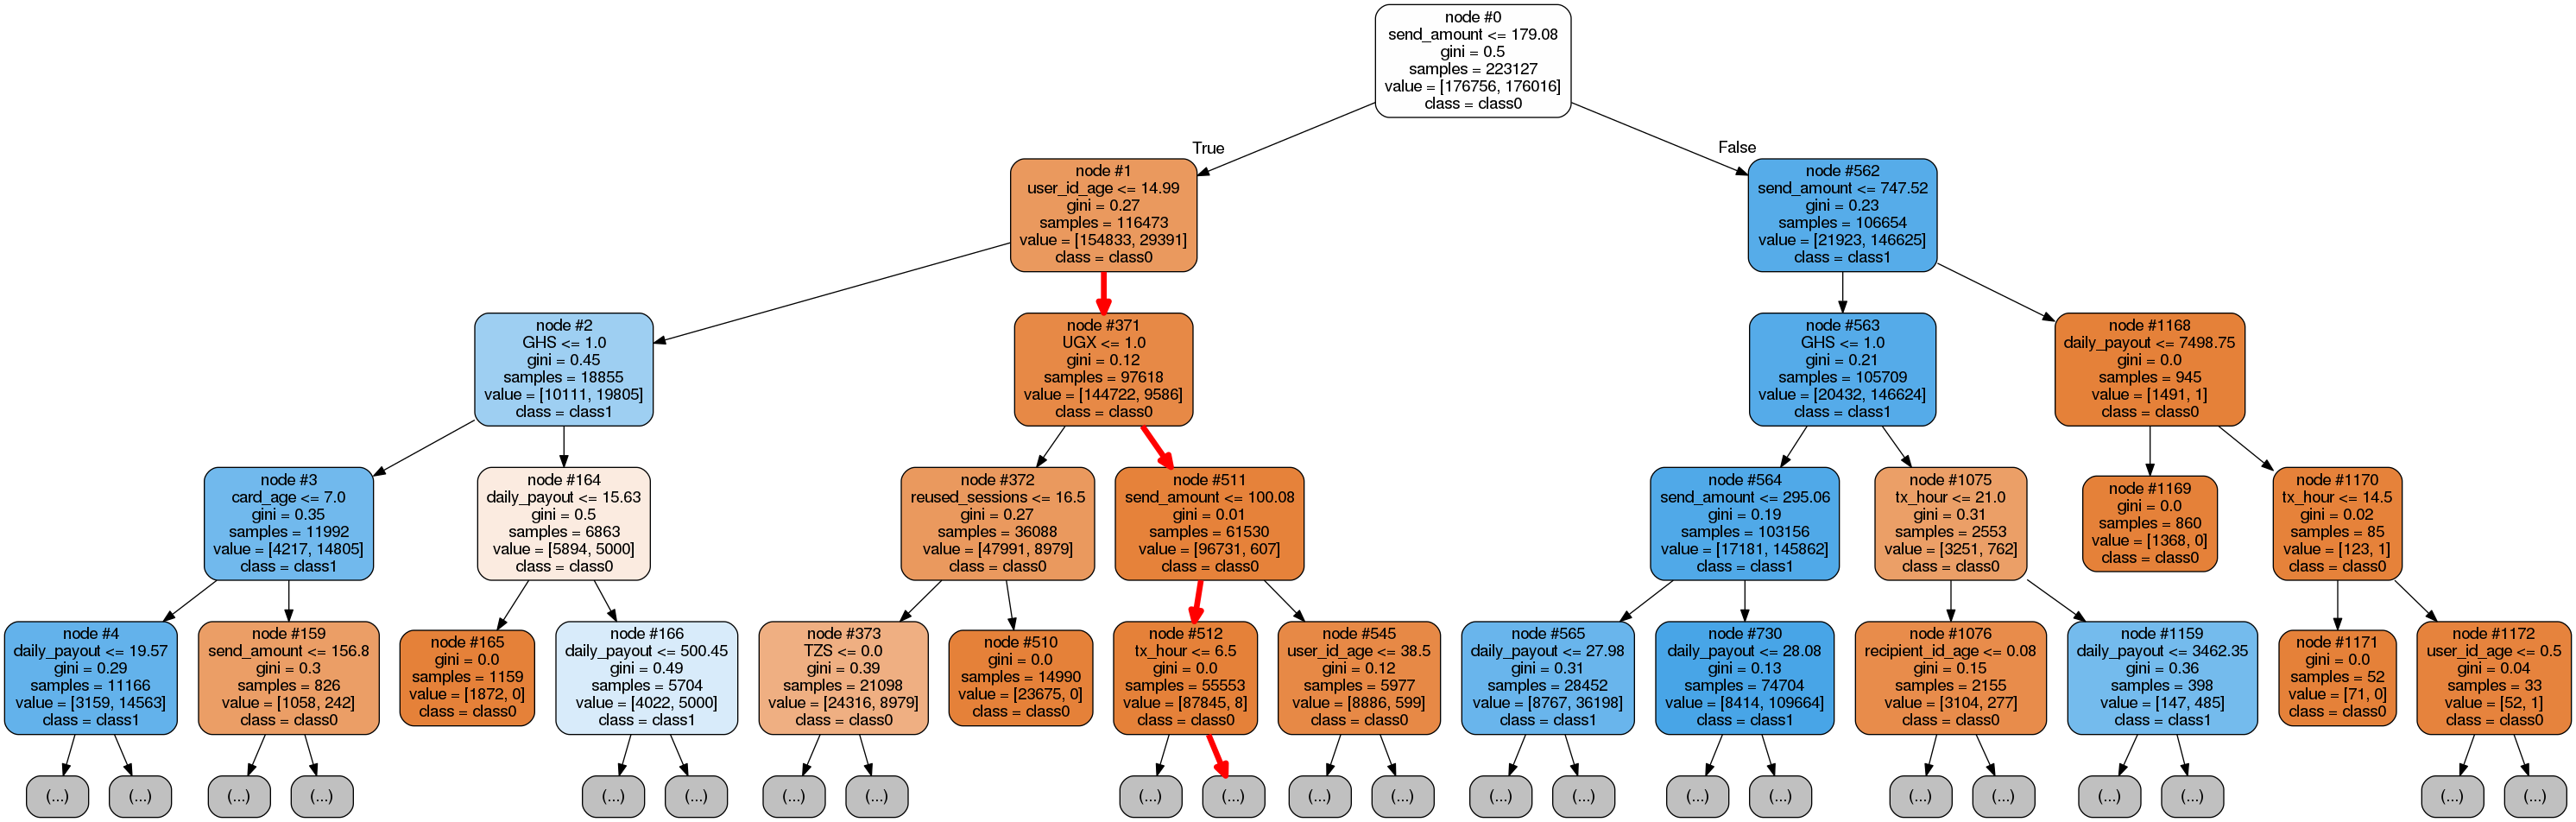

In [16]:
# Plot decision path for another sample
idx=110771 
one_sample = X_test.loc[idx]
disp(one_sample)
print('fraud:', y_test.loc[idx])
print(f"Our random forest classifier is composed of {len(rf_model.estimators_)} decision trees")
estimator = rf_model.estimators_[5] 
decision_path = estimator.decision_path(one_sample.values.reshape(1,-1))
class_names = ['class0','class1']
feat_names = X_train.columns.values
path_nodes = format_decision_path(decision_path,verbose=True)
graph = get_graph(estimator,feat_names,class_names,max_depth=4) #the decision tree is large so only show 4 layers
graph_list = mark_path_traversed(path_nodes, graph)
visualize_path(graph_list)

In [17]:
# Verify LAST PREDICTION:
# Ensure that the visualization of the path matches prediction
prediction = estimator.predict(one_sample.values.reshape(1,-1))
prediction # it matches!

array([0.])

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

# PART 4: PREPARE FOR PRODUCTION

# ||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||


In [ ]:
# PICKLE: USE A SINGLE OBJECT AS YOUR ONLY INTERACTION WITH THE PRODUCTION SERVER
# production servers are too complicted
# if they break cause of a bug, they cause financial losses

In [ ]:
# Dump/write the model to a file, to be pushed into production
with open('model.pkl', 'wb') as file:
    pickle.dump(rf_model, file=file)

# Load/read the model from file into production environment
with open('model.pkl', 'rb') as file:
    rf_model = pickle.load(file)
    
pipe = Pipeline([
    ('featurizer', FunctionTransformer(featurize_to_Xy)),
    ('rf_model', RandomForestClassifier(n_estimators=250, class_weight='balanced_subsample', random_state=12, n_jobs=-1).fit(X_train_smote, y_train_smote))])


In [ ]:
# Create a dictionary for X, y
data_dict = { 
                 "X":X,
                 "y":y 
             }
             
# Dump/write the dictionary to a file
with open("data.pkl", "wb") as file:
     pickle.dump(data_dict, file=file)

# Load/read the dictionary into production environment
with open( "data.pkl", "rb" ) as handle:
    pickle_dict = pickle.load(handle)
    X=pickle_dict['X']
    y=pickle_dict['y']